In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt

# BMW Pricing Challenge
https://www.kaggle.com/danielkyrka/bmw-pricing-challenge

Представим, что мы открыли свой магазин по прадаже автобмобилей марки BMW. Узнаем, для себя некоторую статистику, а также постараемся понять, что нас ждёт в первый месяц продаж наших автомобилей.

Будем анализировать датасет, посвящённный продажам машин марки BMW на аукционе b2b в 2018 году. 

Загрузим наш датасет. Работать будем с автомобилями BMW 320 и BMW 520. Подготовим данные в приятном для восприятия виде, переиндексируем строки.

<img width = '400px' src="320.jpg">

<img width = '500px' src="520.jpg">

In [10]:
df = pd.read_csv('bmw_pricing_challenge.csv') 
df1 = df[df['model_key'] == '320']
df2 = df[df['model_key'] == '520']
df = pd.merge(df1, df2, how='outer')
drop_list = ['maker_key'] + ["feature_" + str(i) for i in range(1, 9)]
df = df.drop(drop_list, axis=1)
df.index = np.arange(len(df))

In [11]:
print(df.shape)
df.head()

(1385, 9)


,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,price,sold_at
0,320,183297,120,2012-04-01,diesel,white,convertible,10200,2018-02-01
1,320,139541,135,2013-06-01,diesel,white,convertible,17300,2018-03-01
2,320,77115,135,2012-09-01,diesel,blue,convertible,19300,2018-03-01
3,320,181252,120,2008-08-01,diesel,black,convertible,11100,2018-05-01
4,320,194192,120,2008-07-01,diesel,beige,convertible,11800,2018-07-01


<b>Описание признаков дата сета:</b><br>
<li> model_key - модель автомобиля
<li> mileage - пробег в милях
<li> engine_power - мощность двигателя
<li> registration_date - дата регистрации авто
<li> fuel - тип топлива
<li> paint_color - цвет
<li> car_type - тип кузова
<li> price - цена
<li> sold_ar - дата продажи 

Предсказывать будем price

<b>Распределение цен</b><br>

D:\Anacondas\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


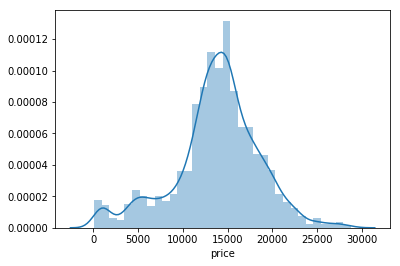

In [33]:
sns.distplot(df['price'])

<b>Кореляция признаков</b><br>

При помощи <b>корреляции Пирсона</b> посмотрим от каких признаков зависит целевая

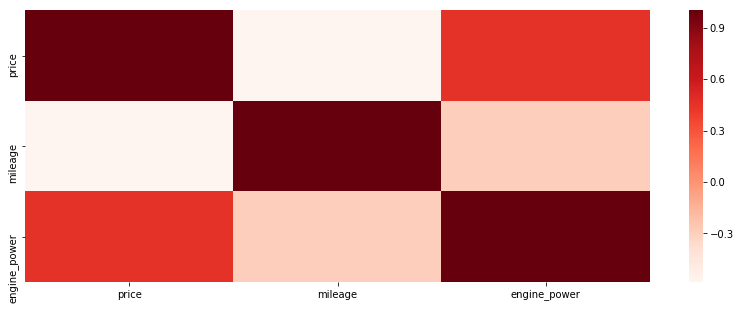

In [13]:
cols = ['price', 'mileage', 'engine_power', 'registration_date', 'fuel', 'car_type', 'sold_at', 'paint_color']
fig = plt.figure(figsize= (14,5))
sns.heatmap(df[cols].corr(), cmap = 'Reds')

По нашей heatmap видно, что единственный признак который влияет на цену машины - мощность её двигателя. Таким образом можно
избавиться от ненужных признаков.

In [14]:
df = df.drop(['mileage', 'registration_date', 'fuel', 'paint_color', 'car_type'], axis=1)

In [15]:
df.head()

,model_key,engine_power,price,sold_at
0,320,120,10200,2018-02-01
1,320,135,17300,2018-03-01
2,320,135,19300,2018-03-01
3,320,120,11100,2018-05-01
4,320,120,11800,2018-07-01


Посмотрим отдельно на распределения для моделей <b>320</b> и <b>520</b> 

In [16]:
df_320 = df[df['model_key'] == '320']
df_520 = df[df['model_key'] == '520']

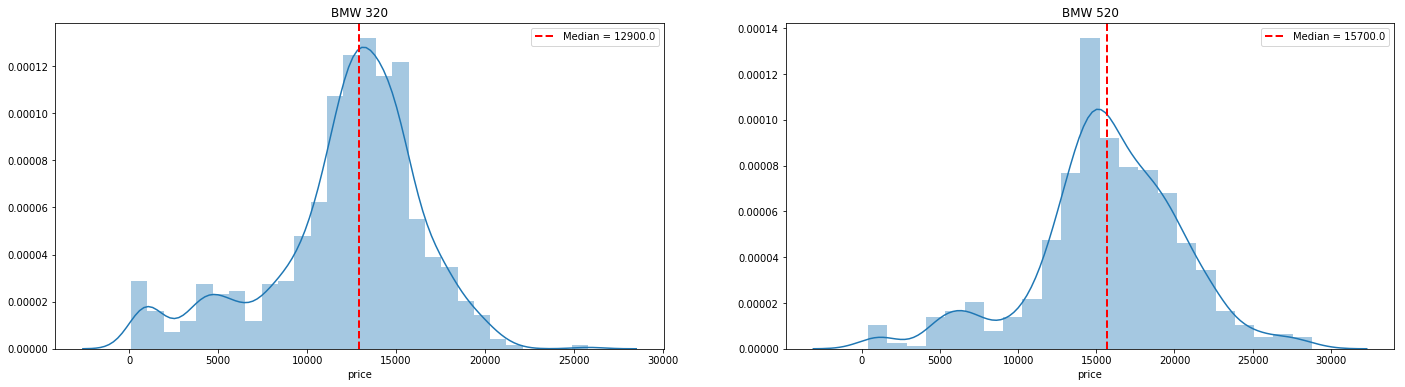

In [17]:
fig = plt.figure(figsize=(24, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

org = sns.distplot(df_320['price'], ax=ax1)
line1 = org.axvline(np.median(df_320['price']), 
                    color='r', linestyle='dashed', 
                    label=('Median = '+str(round(np.median(df_320['price']), 2))), 
                    linewidth=2)
org.set_title('BMW 320')
org.legend(handles=[line1])

conv = sns.distplot(df_520['price'], ax=ax2)
line2 = conv.axvline(np.median(df_520['price']), 
                    color='r', linestyle='dashed', 
                    label=('Median = '+str(round(np.median(df_520['price']), 2))), 
                    linewidth=2)
conv.set_title('BMW 520')
conv.legend(handles=[line2])

По графикам видно, что цена 520 модели несколько выше, чем 320

Проверим обa распределения выборок на нормальность критерием <b>Шапиро-Уилка<b>

In [34]:
print('distribution of df_320', 
      'is normal' if stats.shapiro(df_320['price'][:5000])[1] > 0.05 else 'is not normal',
     '\ndistribution of df_520',
      'is normal' if stats.shapiro(df_520['price'][:5000])[1] > 0.05 else 'is not normal'
     )

distribution of df_320 is not normal 
distribution of df_520 is not normal


Обе выборки имеют не нормальное распределение. Это о многом говорит, какой критерий стоит выбирать при дальнейших исследованиях
, а что уже автоматически можно отбросить.

При помощи критерия <b>Манна-Уитни</b> убедимся в том, 
что цена на <b>520-ую</b> модель несколько выше, чем на <b>320-ую</b>.

In [19]:
stats.mannwhitneyu(df_320['price'], df_520['price'], alternative='greater')

MannwhitneyuResult(statistic=127180.5, pvalue=1.0)

In [20]:
stats.mannwhitneyu(df_320['price'], df_520['price'], alternative='less')

MannwhitneyuResult(statistic=127180.5, pvalue=8.0824283187994e-51)

Цены действительно оказались разными. Поэтому предсказывать цену на следующий месяц имеет смысл для разных моделей по разному

In [53]:
stats.mannwhitneyu(df_320['engine_power'], df_520['engine_power'], alternative='greater')

MannwhitneyuResult(statistic=216924.5, pvalue=0.9990238668998154)

In [54]:
stats.mannwhitneyu(df_320['engine_power'], df_520['engine_power'], alternative='less')

MannwhitneyuResult(statistic=216924.5, pvalue=0.0009766170137519726)

А из последнего предсказания видим, что обусловленная большая цена связана с тем, что в большинстве своём <b>520-ые</b> автомобили мощнее

Построим график цены на 320-ую модель в зависимости от времени:

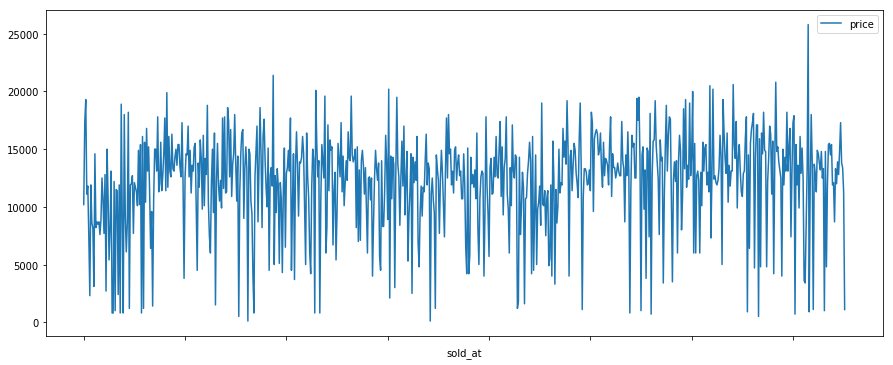

In [21]:
df_320.plot(x='sold_at', y='price', figsize=(15,6))

Тестом <b>Дики-Фуллера</b> проверим ряд на стационарность.

In [22]:
test_ = sm.tsa.adfuller(df['price'])
print ('adf: ', test_[0] )
print ('p-value: ', test_[1])
print('Critical values: ', test_[4])
if test_[0]> test_[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.3103982168900767
p-value:  0.014420024005894518
Critical values:  {'1%': -3.435163869552687, '5%': -2.863665960737661, '10%': -2.567901861810129}
единичных корней нет, ряд стационарен


Ряд стационарен, тренда нет, сезонность также отсутствует. Вывод: имеет смысл применить экспоненциальное сглаживание.

([], <a list of 0 Text xticklabel objects>)

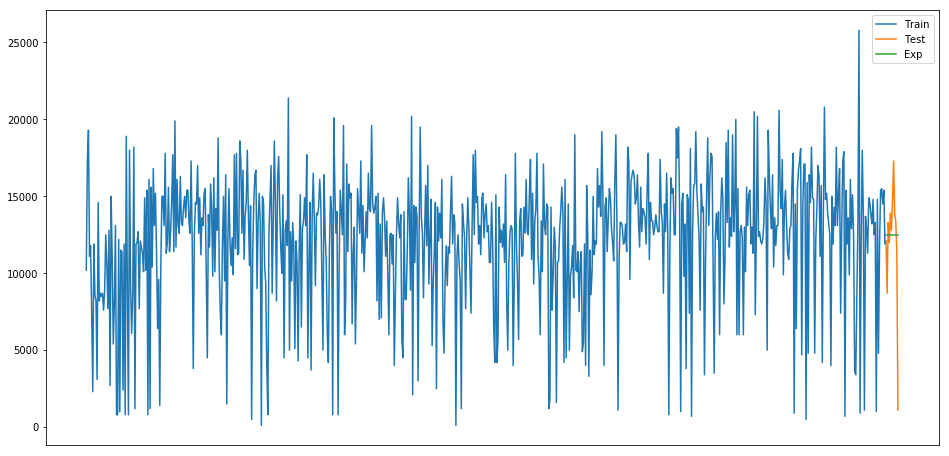

In [39]:
from statsmodels.tsa.api import ExponentialSmoothing

train = df_320[:-11]
test = df_320[-12:]
y_hat = test.copy()
fit = ExponentialSmoothing(np.asarray(train.price)).fit()
y_hat['price'] = fit.forecast(len(test))

fig = plt.figure(figsize=(16,8))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(y_hat['price'], label='Exp')
plt.legend()
plt.xticks([])

Так как наш магазин открылся недавно, пессимистическое предсказание имеет большую ценность.